# The following studies is a continuation of the first Customer retention analysis:

In order to better understand how it works Cox regression in relation to study customer loyalty, I choose from "Definitva_1.csv" just three variables(Read Customer Analysis I).
- Churn: binary variable. Whether the customer left or not the online service
- Tenure: the number of months. The cases are filtered by this variable fom 0 months to 72 months.
- SeniorCitizen: binary category, I decided to rename it as "Subscription". 0 for Subscription Standard and 1 for Subscription Premium.

In my first study, [see in my github repository](https://github.com/ElenaP-Github/ORIGINAL-Python-Data-Analysis-projects/blob/main/Customer%20retention%20analysis%20Elena%20Pe%C3%B1a.rar), the proportional hazard regression didn't met the required assumptions because there were few cases that remain in the online service for more months. 
What does it exactly mean proportional rates in this regression?  The more time one is the online service, the less people are leaving the service? I will explain in the present simulation.

In this occasion I did some changes in the database. I changed 0's for 1's in the subjects who stay more time in this online service. 



# Importing Packages

In [1]:
#import BASIC LIBRARIES FOR PREPROCESSING AND EXPLORATORY ANALYSIS

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

#### LIBRARY FOR SURVIVAL ANALYSIS 

from lifelines import*


df = pd.read_excel (r'Definitiva_1_SCRA.xlsx', sheet_name='AIA_Churn_Modelling_Case_Study')
df=df.iloc[:,1:]## I excluded ID variable, I don't need it. 


In [2]:
df.head()

,SeniorCitizen,Churn,tenure
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0


# I rename SeniorCitizen

In [3]:
df.columns.values
df= df.rename(columns= {'SeniorCitizen': "Subscription"})

# Exploratory Analysis

In this ocassion I am going to do lees exploratory analysis. 

###### Tenure Mean by suscription

In [4]:
c=np.round(df.groupby('Subscription').mean(),2);c # mean 

,Churn,tenure
Subscription,,
0,0.26,32.09
1,0.42,33.65


- The month mean of customers who have a Premium Subscription is 33.65

- The month mean of customers who have a Standard Subscription is 32.09

#### Suscription and Churn:  Contigency Table and relative bar chart

In [5]:
df_1=df.copy()

df_1["Churn"]= df_1["Churn"].map({0:"No", 1:"Yes"})
df_1["Subscription"]= df_1["Subscription"].map({0:"Standard", 1:"Premium"})

Churn,No,Yes,Total
Subscription,,,
Premium,10.63,7.60,18.23
Standard,60.39,21.38,81.77
Total,71.02,28.98,100.00


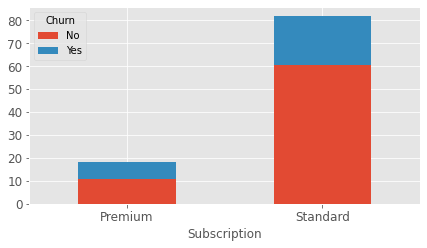

<Figure size 576x432 with 0 Axes>

In [6]:

x= pd.crosstab(index=df_1['Subscription'] ,
            columns=df_1['Churn'], 
               rownames=["Subscription"]).apply(lambda r: r/len(df_1) *100,axis=0).plot(kind='bar', stacked= True);
plt.grid(True)
plt.tight_layout() 
plt.yticks(fontsize=12)
plt.xticks(rotation=360, fontsize=12);

fig = plt.figure(figsize=(8,6));

cont= pd.crosstab(index =df_1['Subscription'],
            columns=df_1['Churn'],  margins=True, margins_name="Total", rownames=["Subscription"], colnames=["Churn"]).apply(lambda r: r/len(df_1) *100,
                               axis=0);np.round(cont, 2)


* 18.23 % of total customers have Premium Subscription
* 81.77 % of total customers have Standard Subscription
###### A 28.98 % of total customers have stopped using the online service

### Are the variables(by tenure) following a normal distribuition?


Statistics :0.84, p_value:0.0
The distribution differs from normal

Statistics :0.93, p_value:0.0
The distribution differs from normal

The group  who have a online Suscription and are censored 
 Skewness:-0.3111425345417101 Kurtosis:-1.3472854207015348

The group  who have a online Suscription and are censored 
 Skewness:0.8783728049266444 Kurtosis:-0.38070260850720583


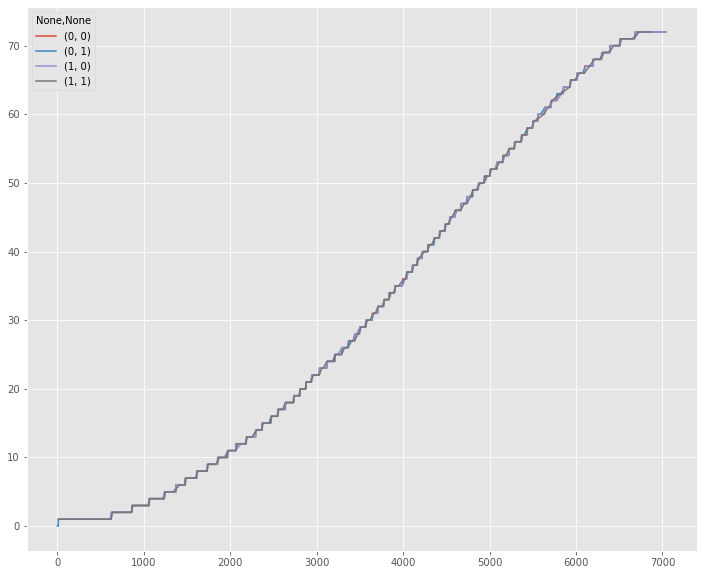

In [7]:
mask=(df['Subscription']==1) & (df['Churn']==0)
mask1=(df['Subscription']==1) & (df['Churn']==1)
plt.figure()
df.groupby(['Subscription','Churn'])['tenure'].plot(legend=True, figsize=(12,10))

#Normality tests
from scipy import stats
def normal(col):
    ks_test=stats.kstest(col,'norm')
    print(f'\nStatistics :{np.round(ks_test[0],2)}, p_value:{np.round(ks_test[1],2)}')                                             
    if ks_test[1] < 0.05:
        return  print('The distribution differs from normal')
    else:
        return  print('The distribution is normal')
normal(df[mask1]['tenure'])
normal(df[mask]['tenure'])

def skew_kurt(col):
    return print('\nThe group  who have a online Suscription and are censored \n Skewness:{0} Kurtosis:{1}'.format(stats.skew(col),stats.kurtosis(col)))

skew_kurt(df[mask]['tenure'])
skew_kurt(df[mask1]['tenure'])

# Survival Analysis

Survival analysis is a branch of statistics for analyzing the expected duration of time until one event happen, such as death in biological organisms and failure in mechanical systems. This topic is called reliability theory or reliability analysis in engineering, duration analysis or duration modelling in economics, and event history analysis in sociology. Survival analysis attempts to answer certain questions, such as what is the proportion of a population which will survive past a certain time? Of those that survive, at what rate will they die or fail? Can multiple causes of death or failure be taken into account? How do particular circumstances or characteristics increase or decrease the probability of survival?

To answer such questions, it is necessary to define "lifetime".[...] More generally, survival analysis involves the modelling of time to event data; in this context, death or failure is considered an "event" in the survival analysis literature – traditionally only a single event occurs for each subject, after which the organism or mechanism is dead or broken. Recurring event or repeated event models relax that assumption. The study of recurring events is relevant in systems reliability, and in many areas of social sciences and medical research.

[Wikipedia](https://en.wikipedia.org/wiki/Survival_analysis)


## Kaplan Meier analysis


The survival function S(t), is the probability that a subject survives longer than time t. S(t) is theoretically a smooth curve, but it is usually estimated using the Kaplan–Meier (KM) curve. The graph shows the KM plot for the aml data and can be interpreted as follows:

    The x axis is time, from zero (when observation began) to the last observed time point.
    The y axis is the proportion of subjects surviving. At time zero, 100% of the subjects are using the product without an event.
    The solid line (similar to a staircase) shows the progression of event occurrences.
    A vertical drop indicates an event. 
    

Let's explore the customer behaviour without using different customer groups

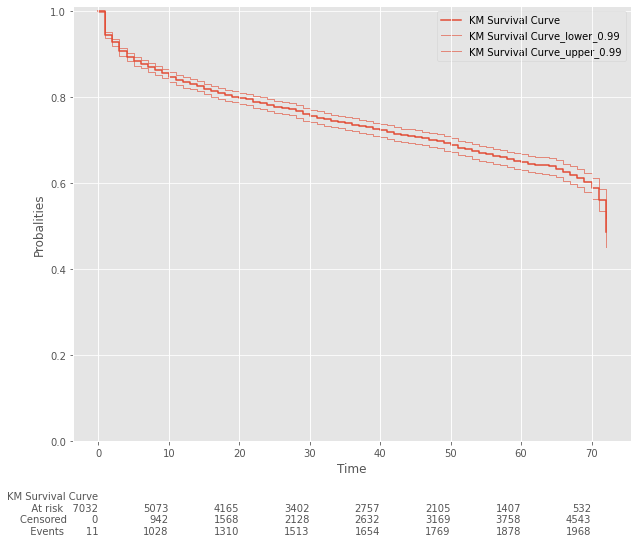

In [8]:
def plot_km_survf(data, t_col="t", e_col="e"):
    from lifelines import KaplanMeierFitter
    from lifelines.plotting import add_at_risk_counts
    fig, ax = plt.subplots(figsize=(8, 6))
    kmf = KaplanMeierFitter()
    kmf.fit(data[t_col], event_observed=data[e_col], label="KM Survival Curve", alpha=0.01)
    kmf.plot(figsize=(10,8), ci_alpha= 0.01,show_censors=False, ci_legend=True, ci_force_lines=True, ax=ax); # the former graph is an internal lifelines plotting graph, which includes confidence intervals and a step-wise visualization
    plt.ylim(0, 1.01)
    plt.xlabel("Time")
    plt.ylabel("Probalities")
    plt.legend(loc="best")
    add_at_risk_counts(kmf, ax=ax)
    plt.show() 
    
plot_km_survf(df, t_col="tenure", e_col="Churn")

A homogeneous slope indicates that the subjects are steadily leaving the online service, by the 70th month there is a vertical slope, it means a drastical humber change o f customers. 


- Events: Subjects that left the service

- Censored:Participant is said to be censored when information on time to event is not available due to loss to follow-up or non-occurrence of outcome event before the trial end.

- At risk: Number of cases that have the possibility of experiencing the event(Churn) in each time interval. 

By the 70th Month:
- There are 532 customers at risk of leaving the online service.
- The information about 4543 customers is not available. 
- 1968 customers have left the online service. 
- Around a 45% out of the customers are still using the product

## Proportional hazard regression and Breslow Estimation

The Cox proportional-hazards model (Cox, 1972) is essentially a regression model commonly used statistical in medical research for investigating the association between the survival time of patients and one or more predictor variables.

The Kaplan-Meier curves and logrank tests - are examples of univariate analysis. They describe the survival according to one factor under investigation, but ignore the impact of any others.

Additionally, Kaplan-Meier curves and logrank tests are useful only when the predictor variable is categorical (e.g.: treatment A vs treatment B; males vs females). They don’t work easily for quantitative predictors such as gene expression, weight, or age.

An alternative method is the Cox proportional hazards regression analysis, which works for both quantitative predictor variables and for categorical variables. Furthermore, the Cox regression model extends survival analysis methods to assess simultaneously the effect of several risk factors on survival time.

The purpose of the model is to evaluate simultaneously the effect of several factors on survival. In other words, it allows us to examine how specified factors influence the rate of a particular event happening (e.g., infection, death) at a particular point in time. This rate is commonly referred as the hazard rate. Predictor variables (or factors) are usually termed covariates in the survival-analysis literature.

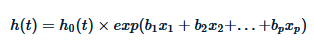

where,


    t represents the survival time
    h(t)is the hazard function determined by a set of p covariates (x1,x2,...,xp)
    the coefficients (b1,b2,...,bp) measure the impact (i.e., the effect size) of covariates.
    the term h0 is called the baseline hazard. It corresponds to the value of the hazard if all the xi are equal
    to zero (the quantity exp(0) equals 1). The ‘t’ in h(t) reminds us that the hazard may vary over time.

The Cox model can be written as a multiple linear regression of the logarithm of the hazard on the variables xi
, with the baseline hazard being an ‘intercept’ term that varies with time.

The quantities exp(bi)are called hazard ratios (HR). A value of bi greater than zero, or equivalently a hazard ratio greater than one, indicates that as the value of the ith covariate increases, the event hazard increases and thus the length of survival decreases.

Put another way, a hazard ratio above 1 indicates a covariate that is positively associated with the event probability, and thus negatively associated with the length of survival.

To sum up,

    HR = 1: No effect
    HR < 1: Reduction in the hazard
    HR > 1: Increase in Hazard

[Click here for reading more about it:](http://www.sthda.com/english/wiki/cox-proportional-hazards-model)

In [9]:
from lifelines import CoxPHFitter
cph = CoxPHFitter().fit(df,"tenure", "Churn")
cph.print_summary()
axes = cph.check_assumptions(df,  p_value_threshold=0.01, advice=True, show_plots=True)

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5002 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 2041
   partial log-likelihood = -16899.01
         time fit was run = 2021-05-01 06:37:50 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
Subscription   0.44       1.55       0.05             0.34             0.54                 1.41                 1.71

                z      p   -log2(p)
covariate                          
Subscription 8.74 <0.005      58.63
---
Concordance = 0.53
Partial AIC = 33800.01
log-likelihood ratio test = 71.00 on 1 df
-log2(p) of ll-ratio test = 54.64

Proportional hazard assumption looks okay.


Note: the Hazard ratio is 1.55 which indicates the Susbcription covariate is positively associated with the event  probability(the probability that the customer give up the online service).

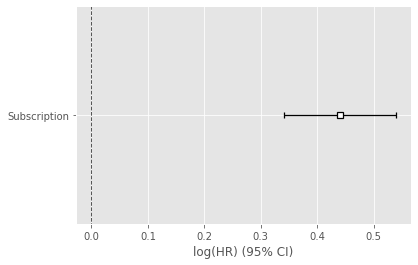

In [10]:
cph.plot();# confidence interval of Subscription. Proportional hazard assumption was met (p-value:>0.01)

## Which estimation is used for comparing the survival time of two or more groups?

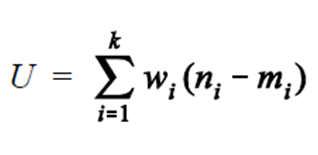

The most commonly known test is a log-rank test (or Cox-Mantel test) The test determines the difference between expected and observed number of events in participants of two groups. It should be noted that the tests are powerful for stratified 2 x 2 tables, and when the number of groups is larger, the pairwise comparison of the hazard rates is carried out. The hazard ratio is an estimate of the hazard rate in the one group relative to the hazard rate in the other group. If the hazards are proportional, then the ratio will be constant at any interval of time. For example, if the risks of an event for individuals of the one group were twice higher than the hazards in another group at any point of time, the risks of an event would differ double at early or later times as well. Does it mean that we should find the hazard ratio for all individuals during the whole study period and then compare them at different points? İndeed we may do it in a short-term study, but the task is an arduous if there are too many time interval.The log-rank test has a very important assumption of proportional hazards to examine. İn a such situation the estimation of survival curves is very useful; one says that if the curves are parallel of the same shape the hazard ratio is constant and logrank test results are reliable.

On the other hand, when the hazard ratio is not constant, the log-rank statistic loses its power to detect the difference in survival probabilities between the groups.12 Under such circumstances, the Gehan-Breslow-Wilcoxon test should be used.This procedure does not require the assumption of the proportional hazards to be met, as a result some scientists use it as the alternative to the Mantel-Haenszel statistic. Nevertheless, the later studies indicated that the Wilcohon test might yield more reliable results for the data with a constant hazard ratio as well. 

Researchers, however, also found that when the survival curves cross, neither test becomes reliable. An excessive focus on the proportional hazards in the data can lead to the improper use of the test. Hence, Tarone and Ware advise to pay more attention to the period when the most of the events were occurring rather than the equality of the hazards. The Gehan’s generalized Wilcohon test is said to give more weight to the early failures while the log-rank statistic is more suitable for the data with later events.

[Click here for reading more about:](https://medcraveonline.com/BBIJ/choosing-statistical-tests-for-survival-analysis.html)

### Differences between Breslow and log rank estimations: 


Log rank: wi = 1; i.e, all events are equally weighted.

The log-rank test compares the survival times of two or more groups. 

The null hypothesis for a log-rank test is that the groups have the same survival. The expected number of subjects surviving at each time point in each is adjusted for the number of subjects at risk in the groups at each event time. The log-rank test determines if the observed number of events in each group is significantly different from the expected number. The formal test is based on a chi-squared statistic. When the log-rank statistic is large, it is evidence for a difference in the survival times between the groups. The log-rank statistic approximately has a chi-squared distribution with one degree of freedom, and the p-value is calculated using the chi-squared distribution.

Breslow: weight wi = r

Meanwhile the null hypothesis for a Breslow test is supposed that the groups have different survival rates; the survival rates are weighted by the exposed number of subjects at the time the event occurs. Therefore, it means that the events at the beginning are more heavily weighted than those at the end, since the exposed number of subjects decreases as time goes by.

Resource: Pardo, A.; Ruiz, M.A. (2012). Análisis de datos en ciencias sociales y de la Salud III.

# Log Rank

Let's analyze by groups of Subscription

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          77.89 <0.005     59.67

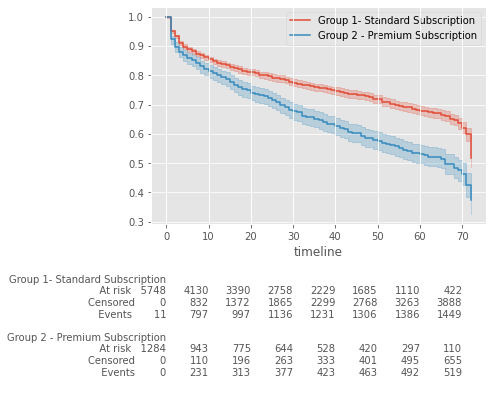

In [11]:
#KM curve
from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
group1=df[df['Subscription']==0]
group2=df[df['Subscription']==1]
T=group1['tenure']
E=group1['Churn']
T1=group2['tenure']
E1=group2['Churn']

kmf_1 = KaplanMeierFitter()
kmf_2 = KaplanMeierFitter()

ax = plt.subplot(111)
ax_ = kmf_1.fit(T, E, label="Group 1- Standard Subscription").plot(ax=ax)
ax_1 = kmf_2.fit(T1, E1, label="Group 2 - Premium Subscription").plot(ax=ax)
add_at_risk_counts(kmf_1,kmf_2, ax=ax)

#logrank_test
from lifelines.statistics import logrank_test
results=logrank_test(T,T1,event_observed_A=E, event_observed_B=E1)
results.print_summary()

The "Premium Subscription" curve is decreasing more quickly than the Standard one.

And it's important to remember there are less Premium customers than Standard.

By the 70th Month by groups:


- The customers number which is at risk of leaving the online service.

   - Standard:422 customers
   
   - Premium: 110 customers
   
   
- The information about customers is not available by groups.

   - Standard: 3888 customers
   
   - Premium: 655 customers
   
   
- The number of customer which gave up already the service by groups.

   - Standard: 1449 customers
   
   - Premium: 519 customers
   
   - 1968 customers have left the online service. The 28% out of total customer number have left the service
   
   
+ Around a 50% out of the Standard customers are still using the product. (As I can see in survival plot)


+ Around a 38% out of the Premium customers are still using the product.(As I can see in survival plot)

In this kind of project, it's not needed to look for the best features, in order to explain better the customer loyalty;
To sum up, I would say that log rank is a nice tool to observe differences between groups in terms of how long was the product used.

In another hand, Proportional Hazard Regression is needed for detecting which other factors can have influence in predicting the Churn, considering already Tenure (or time in Months) as Churn covariate.

It was worthy to make smaller this first project [Customer Analysis I](https://github.com/ElenaP-Github/ORIGINAL-Python-Data-Analysis-projects/blob/main/Customer%20retention%20analysis%20Elena%20Pe%C3%B1a.rar).

The more simple, the better one can understand.

## Guidelines for next customer analysis (III)


For a next stage, I want to take MonthlyCharges and Total Charges (from Customer Analysis I) and transform them in ordinal variables. Then I want to do again a multiple Cox regression, looking for new insights from the data.

In Customer Analysis I: Log rank may have poorly performed due to there weren't stable proportional hazard rates. However, the survival rates were less vertical than the ones I have done in this present simulation.

# References

https://medium.com/analytics-vidhya/log-rank-test-kaplan-meier-survival-curve-python-code-3fc78da644d5